In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from pandas.plotting import scatter_matrix
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [2]:
# Add the scripts folder to the system path
import sys
sys.path.append("../scripts")

In [3]:
from data import load_data

In [4]:
data = load_data('housing.csv')

Successfully loaded data from housing.csv.


### Handling Missing Data
To ensure clean and consistent data for analysis, rows with missing values were removed using the `dropna()` function. This step is crucial for maintaining data integrity in subsequent visualizations and model development.  

- **Why?** Missing values can distort statistical analysis and model performance.  
- **How?** The `inplace=True` parameter modifies the dataset directly without creating a new copy.


In [5]:
data.dropna(inplace=True)

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

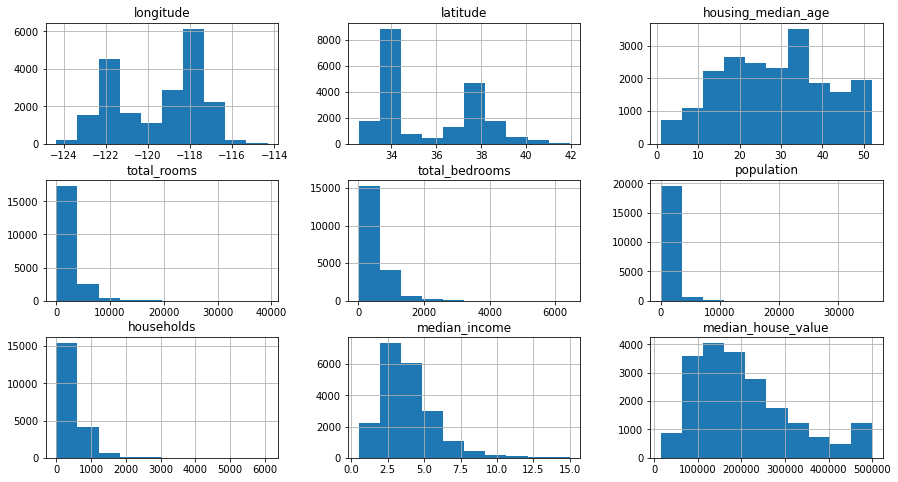

In [6]:
data.hist(figsize=(15,8))

### Distribution of Features
The histogram plot above visualizes the distribution of numerical features in the dataset. It provides insight into the spread, central tendency, and potential skewness of each feature. 

- **What to look for?**  
   - **Skewness:** Some features exhibit right or left skewness, indicating a need for transformation which is done later (e.g., log transformations).  
   - **Outliers:** The presence of extreme values may suggest that certain features require further attention or outlier handling.
   - **Feature range and spread:** It helps us understand the scale of each feature, which can be crucial for preprocessing steps like scaling.

The `figsize=(15,8)` ensures that the plot is large enough for better visualization of all features.


<Axes: >

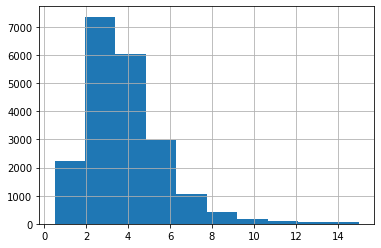

In [7]:
data["median_income"].hist()

### Distribution of Median Income
The histogram above visualizes the distribution of the `median_income` feature. This helps us understand the spread and central tendency of income in the dataset.

- **What to look for?**
   - **Skewness:** The distribution of `median_income` might show skewness, which can provide insights into the income structure of the dataset.
   - **Bimodal Distribution:** If the histogram shows two peaks, it may indicate two distinct income groups in the population, suggesting that further analysis of these groups might be useful.
   - **Range:** It’s important to observe the range of `median_income` values to ensure that they are within expected bounds and identify any potential outliers.


In [8]:
#dividing median income into income categories

data["income_cat"] = np.ceil(data["median_income"] / 1.5)

#putting everything above the 5th category as the 5th category

data["income_cat"].where(data["median_income"] < 5, other=5.0 , inplace = True)

### Creating Income Categories
In this step, we divide the `median_income` feature into discrete income categories. The income is divided by 1.5 and rounded up using `np.ceil()` to create five distinct categories. 

- **Step-by-step breakdown:**  
   - The median income is first divided by 1.5, and then the resulting value is rounded up to the nearest integer to form the `income_cat` column.
   - Any values greater than or equal to the 5th category are capped to 5.0, ensuring that all values above this threshold are treated as belonging to the highest income category.

This categorization will be useful in the stratified sampling process to ensure that each income category is represented proportionally when splitting the data into training and test sets.


In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=29)

for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_split = data.iloc[train_index]
    strat_test_split = data.iloc[test_index]

### Stratified Splitting of the Data
In this step, we perform a **Stratified Shuffle Split** to divide the dataset into training and test sets while ensuring that the distribution of income categories is preserved.

- **What does this do?**  
   - The `StratifiedShuffleSplit` is used to split the data into two subsets (train and test) while maintaining the proportion of each income category (from the `income_cat` column) in both subsets. This prevents any bias due to uneven distribution of income categories in the dataset.
   - The `test_size=0.2` parameter ensures that 20% of the data is reserved for testing, and `random_state=29` ensures reproducibility of the split.

The `train_index` and `test_index` arrays contain the indices for the train and test subsets, respectively, which are then used to create `strat_train_split` and `strat_test_split` by selecting the corresponding rows from the original dataset.

This stratified sampling technique is important to ensure that the model is trained and evaluated on a dataset that reflects the overall distribution of income categories, which helps in mitigating potential bias.


In [69]:
strat_train_split["income_cat"].value_counts() / len(strat_train_split)


income_cat
3.0    0.350239
2.0    0.318855
5.0    0.218586
4.0    0.072495
1.0    0.039826
Name: count, dtype: float64

In [66]:
strat_test_split["income_cat"].value_counts() / len(strat_test_split)

income_cat
3.0    0.350135
2.0    0.318816
5.0    0.218498
4.0    0.072669
1.0    0.039883
Name: count, dtype: float64

**As seen above the proportions are maintained using Stratified sampling**

**[why stratified?]** : because the feature space is less and we are using a medium sized dataset, we do not want to miss out on any class  

In [12]:
test_set, train_set = train_test_split(data, test_size=0.2, random_state=29)

In [13]:
def income_cat_proportions(Dataset):
    return Dataset['income_cat'].value_counts() / len(Dataset)

comparing_props = pd.DataFrame({
    "Overall Props" : income_cat_proportions(data),
    "Random" : income_cat_proportions(test_set),
    "Stratified" : income_cat_proportions(strat_test_split)
}).sort_index()

comparing_props["random %error"] = 100 * comparing_props["Random"] / comparing_props["Overall Props"] - 100
comparing_props["strat. %error"] = 100 * comparing_props["Stratified"] / comparing_props["Overall Props"] - 100
comparing_props

,Overall Props,Random,Stratified,random %error,strat. %error
income_cat,,,,,
1.0,0.039838,0.039643,0.039883,-0.488965,0.113051
2.0,0.318847,0.320996,0.318816,0.673991,-0.009787
3.0,0.350218,0.347180,0.350135,-0.867474,-0.023760
4.0,0.072530,0.072434,0.072669,-0.132509,0.192622
5.0,0.218568,0.219748,0.218498,0.539854,-0.032176


### Stratified Sampling vs. Random Sampling

The table above compares the proportion of each income category (`income_cat`) in the overall dataset, the random sample, and the stratified sample. It also includes the percentage error between the random and stratified samples compared to the overall dataset.

#### Key Insights:

- **Random Sampling Error**: When using random sampling, certain categories (such as `income_cat = 1.0`) exhibit substantial errors. For instance, the `random %error` for category 1.0 is **-0.49%**, which suggests that the random split under-represented this category. While this error may seem small, it shows that random sampling can distort the representation of smaller categories, especially when the distribution of the data is skewed.
  
- **Stratified Sampling Error**: On the other hand, stratified sampling produces a much closer match to the overall proportions, with an error of just **+0.11%** for category 1.0, meaning it keeps the categories balanced across the training and test sets. This is crucial, especially for categories with fewer instances like `income_cat = 1.0`, which may be missed with random sampling.

- **Category Distribution**: The income categories with higher overall proportions, like `income_cat = 3.0` (35%), are well represented in both random and stratified splits. However, random sampling can still cause small discrepancies in how these categories are distributed compared to the stratified approach.

#### Why Stratified Sampling Matters:
Stratified sampling ensures that each income category is proportionally represented in both training and test datasets. This helps avoid the scenario where underrepresented categories in a random sample may lead to biased model training, especially when a category has a small number of examples.

In this case, stratified sampling minimizes the percentage error across all income categories and preserves the overall distribution, making it a more reliable method for ensuring balanced training and evaluation.



In [14]:
strat_train_set = data.iloc[train_index].copy()

In [16]:
strat_train_set.drop("income_cat", axis=1, inplace=True)


The above removes the income_cat column, which was only used for stratification and is no longer needed for further analysis.

In [17]:
# Now define x and y from the clean training and testing sets
x_train = strat_train_set.drop(['median_house_value'], axis=1)
y_train = strat_train_set['median_house_value']

### Defining Training Features and Target  
In this step, we separate the clean training set into features (`x_train`) and the target variable (`y_train`):  

- **`x_train`:** Contains all the predictor variables, excluding the target variable `median_house_value`.  
- **`y_train`:** Contains the target variable, which represents the house values we aim to predict.  

This separation is crucial to prepare the data for model training and evaluation.


In [18]:
train_data = x_train.join(y_train)

joinng x and y training data so we can analyse some basic corrolations 

In [19]:
train_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
614,-122.15,37.74,49.0,1494.0,316.0,611.0,288.0,2.2000,NEAR BAY,187500.0
14273,-117.13,32.69,36.0,1469.0,400.0,1271.0,340.0,1.0430,NEAR OCEAN,90100.0
7778,-118.08,33.91,30.0,3259.0,942.0,2744.0,895.0,2.8608,<1H OCEAN,165600.0
19076,-122.49,38.29,26.0,1726.0,289.0,672.0,251.0,3.8000,<1H OCEAN,242100.0
1975,-120.72,38.57,8.0,892.0,185.0,427.0,164.0,2.6833,INLAND,118800.0
...,...,...,...,...,...,...,...,...,...,...
8287,-118.15,33.77,41.0,3448.0,896.0,1621.0,838.0,4.5000,NEAR OCEAN,339800.0
1960,-120.67,38.76,35.0,2104.0,403.0,1060.0,400.0,2.1682,INLAND,138100.0
3351,-121.02,40.51,17.0,890.0,167.0,406.0,154.0,3.3036,INLAND,78300.0
8055,-118.18,33.85,44.0,1890.0,465.0,1378.0,430.0,3.8819,<1H OCEAN,143200.0


<Axes: >

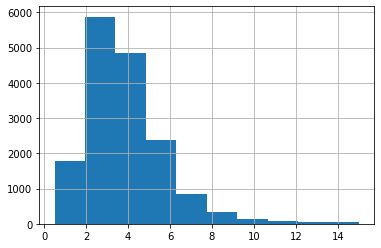

In [20]:
train_data["median_income"].hist()

### Distribution of Median Income  

The histogram above displays the distribution of the `median_income` feature, which appears to be a key variable in predicting house values based on prior analysis.  

- **Purpose of Analysis:**  
   Visualizing `median_income` helps us understand its range, skewness, and overall distribution in the training data.  

- **Observations:**  
   - The feature seems to have a right-skewed distribution, with most values concentrated in the lower range.  
   - This suggests the presence of a few high-income regions that may influence housing values disproportionately.  

Further analysis will explore its relationship with `median_house_value` to confirm its importance.


A heat map to show the correlation with the target variable 'median house value' using the heat map to visualise a correlation matrix

<Axes: >

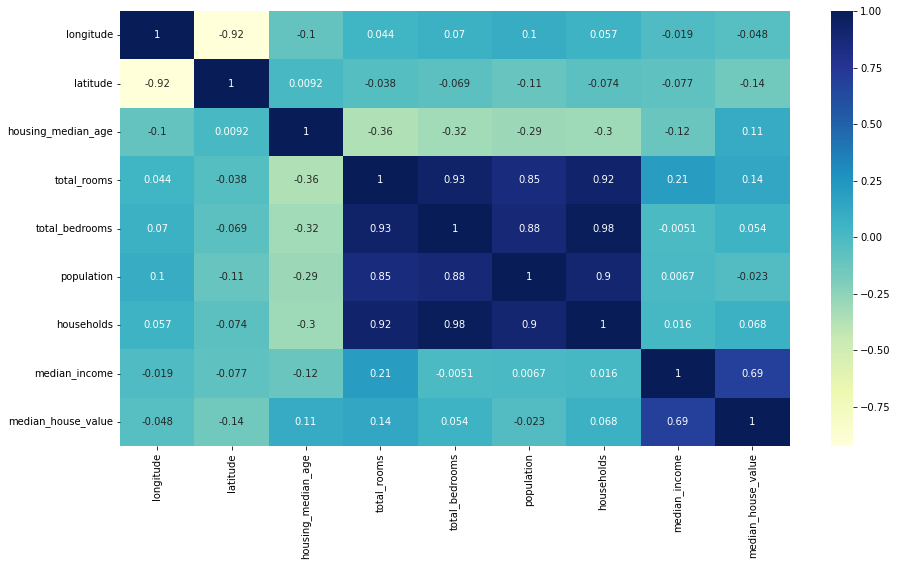

In [21]:
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(numeric_only=True), annot=True, cmap="YlGnBu")

### Correlation Heatmap

The heatmap above displays the correlation coefficients between numerical features in the dataset. It highlights the linear relationships among the features, providing insights into which variables are most strongly related.

- **Key Observations:**  
   - **Strong Positive Correlations:**  
      - `totalBedrooms` and `households` (0.98), as well as `totalRooms` and `totalBedrooms` (0.93), show strong positive correlations, which suggests these features are closely related and might be redundant.  
      - `medianIncome` shows a **moderate positive correlation** with `medianHouseValue` (0.69), indicating it is an important predictor for house values.  
   - **Negative Correlations:**  
      - `longitude` and `latitude` are negatively correlated (-0.92), reflecting the spatial relationship of locations in California.  
   - **Low Correlations:**  
      - Features like `housingMedianAge`, `latitude`, and `longitude` have relatively low correlations with `medianHouseValue`, suggesting weaker linear relationships.  

- **Insights:**  
   - Highly correlated features such as `totalRooms`, `households`, and `population` may cause multicollinearity issues during modeling and may require further preprocessing or dimensionality reduction.  
   - `medianIncome` stands out as a critical feature for predicting `medianHouseValue`.  
   - Understanding these relationships helps guide feature selection and engineering steps to improve model performance.

The `YlGnBu` color map clearly distinguishes the correlation strengths: dark blue represents strong positive correlations, while light yellow indicates strong negative correlations.


In [22]:
train_data['total_rooms'] = np.log(train_data['total_rooms'] + 1) 
train_data['total_bedrooms'] = np.log(train_data['total_bedrooms'] + 1)
train_data['population'] = np.log(train_data['population'] + 1)
train_data['households'] = np.log(train_data['households'] + 1)

### Log Transformation of Features

The code applies a logarithmic transformation to four features: `total_rooms`, `total_bedrooms`, `population`, and `households`. This transformation is performed using the formula:

\[
\text{log(feature + 1)}
\]

- **Why Log Transformation?**  
   - **Skewness Reduction:** Log transformations help reduce right-skewness in features with large values and outliers, making the data more normally distributed.  
   - **Improved Model Performance:** Many machine learning algorithms perform better when numerical features are approximately normal.  

- **Features Transformed:**  
   - `total_rooms`  
   - `total_bedrooms`  
   - `population`  
   - `households`  

The addition of `1` ensures no issues with taking the log of zero. This preprocessing step helps stabilize variance and improves the overall interpretability of the features.


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

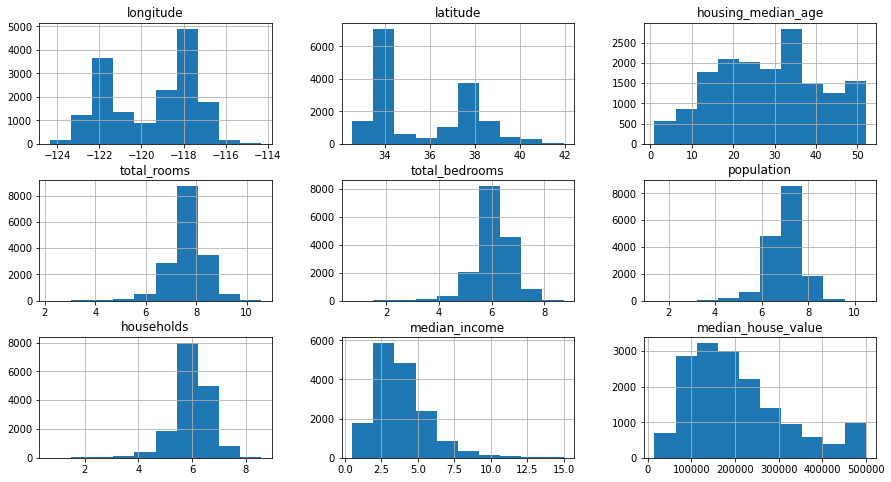

In [23]:
train_data.hist(figsize=(15,8))

The histogram above visualizes the distribution of the numerical features after the log transformation. This transformation reduces the impact of extreme values and spreads the data more evenly across the feature space.

- **What to look for?**  
   - **Normality:** We expect to see a more normalized distribution after applying the log transformation, with features now less skewed and more spread out.
   - **Outliers:** The log transformation helps to bring down the effect of extreme values, making them less dominant in the histograms.


/var/folders/f5/s7tyc7157qvfswnwg8076bhc0000gn/T/ipykernel_30520/2520704375.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='ocean_proximity', palette='viridis')


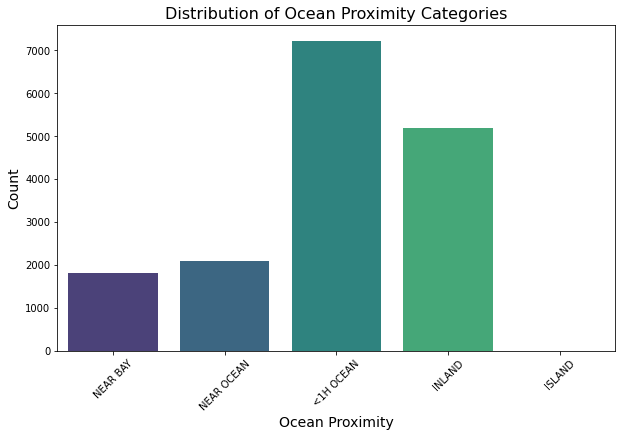

In [24]:
# Visualizing the distribution of the 'ocean_proximity' categorical feature
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='ocean_proximity', palette='viridis')
plt.title('Distribution of Ocean Proximity Categories', fontsize=16)
plt.xlabel('Ocean Proximity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [26]:
# Perform one-hot encoding on the 'ocean_proximity' column with `drop_first` to avoid multicollinearity issues
train_data = pd.get_dummies(train_data, columns=['ocean_proximity'], drop_first=True)


In [30]:
from preprocessing import FeatureEngineering

coastline_points = [
    # Southern California
    (32.5343, -117.1232),  # Imperial Beach near San Diego (close to the border)
    (32.8525, -117.2728),  # La Jolla Shores, San Diego
    (33.5410, -117.7854),  # Laguna Beach
    (34.0092, -118.4976),  # Santa Monica Pier
    (34.0259, -118.7798),  # Malibu Lagoon State Beach

    # Central Coast
    (34.4140, -119.6846),  # East Beach, Santa Barbara
    (35.2819, -120.6596),  # Avila Beach, San Luis Obispo
    (36.5552, -121.9233),  # Point Lobos, Carmel Highlands
    (36.9514, -122.0263),  # Santa Cruz Beach

    # Bay Area
    (37.7735, -122.5154),  # Ocean Beach, San Francisco
    (37.8299, -122.4194),  # Baker Beach, San Francisco
    (38.0573, -122.7562),  # Dillon Beach, Marin County

    # Northern California
    (39.3086, -123.8102),  # Fort Bragg, Mendocino County
    (40.4358, -124.3945),  # Cape Mendocino
    (41.7450, -124.1835)   # Crescent City Beach (near Oregon border)
]

# Instantiate the FeatureEngineering class
feature_engineer = FeatureEngineering(coastline_points=coastline_points)

# Apply feature engineering to train_data
train_data_fe = feature_engineer.fit_transform(train_data)

# Display a preview of the transformed data
train_data_fe.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_INLAND,...,rooms_per_household,high_income_area,residential_density_per_capita,population_density_per_room,population_per_bedroom,income_to_room_ratio,income_per_age_of_housing,household_room_interaction,households_per_income_category,median_age_interaction
614,-122.15,37.74,49.0,2.117445,1.910860,2.003739,1.897084,2.2000,187500.0,False,...,1.116158,0,2.324844,0.946300,1.048605,1.038988,0.044898,92.957115,inf,107.8000
14273,-117.13,32.69,36.0,2.115414,1.945047,2.097815,1.921600,1.0430,90100.0,False,...,1.100861,0,1.051750,0.991681,1.078542,0.493048,0.028972,69.177609,inf,37.5480
7778,-118.08,33.91,30.0,2.207118,2.060395,2.188020,2.053860,2.8608,165600.0,False,...,1.074620,0,2.885771,0.991347,1.061942,1.296170,0.095360,61.615789,inf,85.8240
19076,-122.49,38.29,26.0,2.134656,1.897602,2.016468,1.876320,3.8000,242100.0,False,...,1.137683,1,4.022724,0.944633,1.062640,1.780146,0.146154,48.784307,1.87632,98.8000
1975,-120.72,38.57,8.0,2.053429,1.828693,1.954321,1.809263,2.6833,118800.0,True,...,1.134954,0,2.819377,0.951735,1.068698,1.306741,0.335413,14.474104,inf,21.4664


***Feature Selection Insights:***

"The features median_income, housing_median_age, and total_rooms were selected for scatter matrix analysis based on their correlation with median_house_value, where correlation > |0.5|. Features with weaker correlations were excluded for clarity."

In [32]:
# Perform correlation analysis with the target variable
correlation_threshold = 0.3
selected_features = (
    train_data_fe.corrwith(train_data_fe['median_house_value'])
    .sort_values(ascending=False)
    .loc[lambda x: abs(x) > correlation_threshold]
    .index.tolist()
)
print("Selected Features:", selected_features)


Selected Features: ['median_house_value', 'residential_density_per_capita', 'median_income', 'income_to_room_ratio', 'income_per_household', 'median_age_interaction', 'high_income_area', 'ocean_proximity_INLAND', 'dist_to_coast']


***Correlation Heatmap of Selected Features***

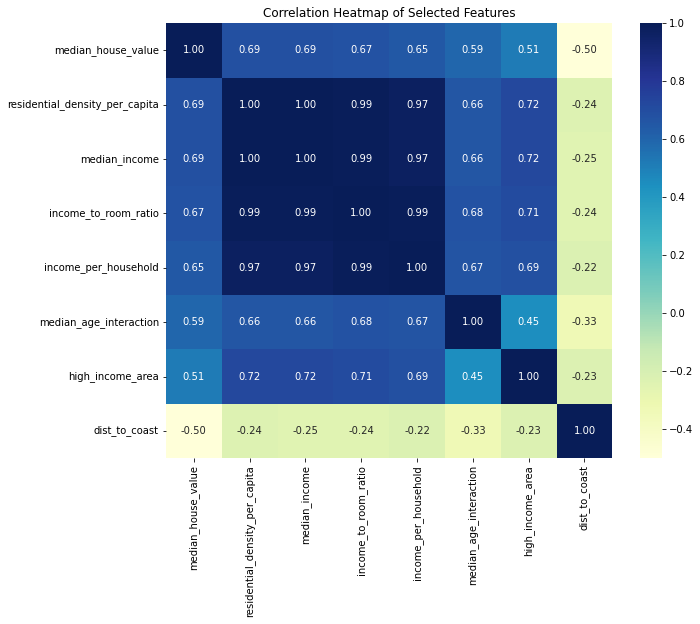

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    train_data_fe[['median_house_value', 'residential_density_per_capita', 
                   'median_income', 'income_to_room_ratio', 
                   'income_per_household', 'median_age_interaction', 
                   'high_income_area', 'dist_to_coast']].corr(), 
    annot=True, cmap="YlGnBu", fmt=".2f"
)
plt.title("Correlation Heatmap of Selected Features")
plt.show()


***Geospatial Analysis: Housing Value and Distance to Coast***

Explore the relationship between housing value and distance to the coast, with differentiation by high_income_area.

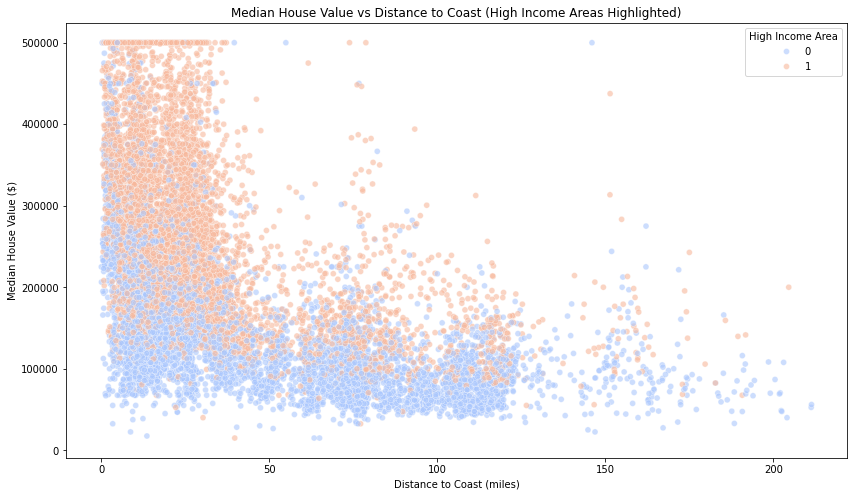

In [39]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='dist_to_coast', 
    y='median_house_value', 
    data=train_data_fe, 
    hue='high_income_area', 
    palette='coolwarm', 
    alpha=0.6
)
plt.title("Median House Value vs Distance to Coast (High Income Areas Highlighted)")
plt.xlabel("Distance to Coast (miles)")
plt.ylabel("Median House Value ($)")
plt.legend(title="High Income Area", loc='upper right')
plt.show()


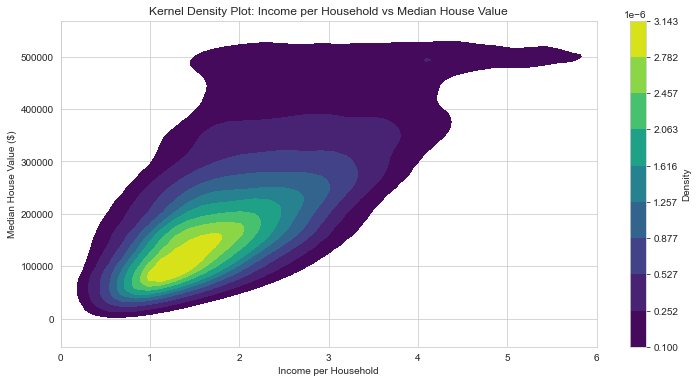

In [64]:


# KDE Plot
plt.figure(figsize=(12, 6))

# Create the KDE plot and ensure a matching colormap
kde = sns.kdeplot(
    x='income_per_household',
    y='median_house_value',
    data=train_data_fe,
    cmap='viridis',   # Explicitly use 'viridis' colormap
    fill=True,
    cbar=True,        # Add color bar automatically
    cbar_kws={'label': 'Density'}  # Label the color bar
)

# Set plot titles and limits
plt.title("Kernel Density Plot: Income per Household vs Median House Value")
plt.xlim(0, 6)  # Limit x-axis to 6
plt.xlabel("Income per Household")
plt.ylabel("Median House Value ($)")

# Show the plot
plt.show()



***Categorical vs Numerical Comparison***

Compare housing values across different categories of ocean_proximity to see geographic influences

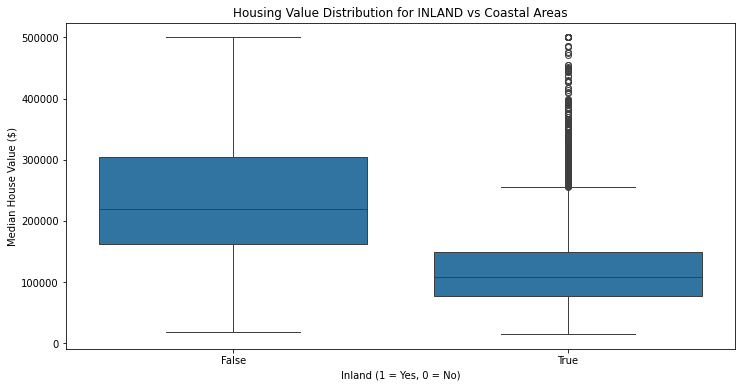

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='ocean_proximity_INLAND', 
    y='median_house_value', 
    data=train_data_fe
)
plt.title("Housing Value Distribution for INLAND vs Coastal Areas")
plt.xlabel("Inland (1 = Yes, 0 = No)")
plt.ylabel("Median House Value ($)")
plt.show()


/var/folders/f5/s7tyc7157qvfswnwg8076bhc0000gn/T/ipykernel_30520/285708752.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label="Median House Value", pad=0.01)


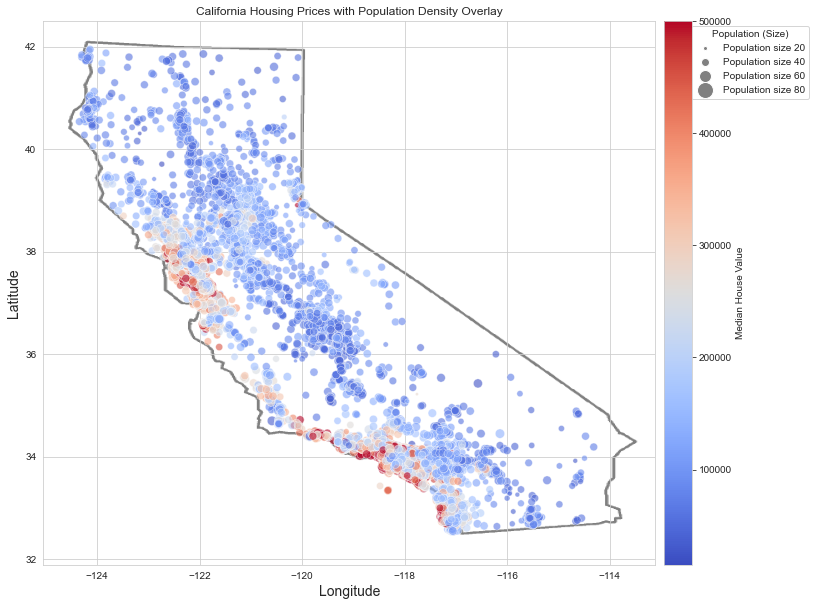

In [46]:
# Load and set up the figure and style
plt.figure(figsize=(19, 10))
sns.set_style("whitegrid")
ax = plt.gca()

# Load the map and adjust extent to fit the California map overlay with fine-tuning
longitude_margin_left = 0.7  # Slightly increased to adjust map position
longitude_margin_right = 1.2
latitude_margin_bottom = 0.65
latitude_margin_top = 0.55

# Calculate min/max latitude and longitude values for the extent
min_long = train_data["longitude"].min() - longitude_margin_left
max_long = train_data["longitude"].max() + longitude_margin_right
min_lat = train_data["latitude"].min() - latitude_margin_bottom
max_lat = train_data["latitude"].max() + latitude_margin_top

# Display California map image
california_img = mpimg.imread("../images/california_map.png")

plt.imshow(california_img, extent=[min_long, max_long, min_lat, max_lat], cmap="gray", alpha=0.5)

# Scatter plot for housing data overlayed on the map
sns.scatterplot(
    x="longitude", y="latitude", data=train_data,
    size=train_data["population"] / 500, sizes=(0.5, 100),
    hue="median_house_value", palette="coolwarm", legend=None, alpha=0.6
)

# Set labels and title
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.title("California Housing Prices with Population Density Overlay")

# Set x and y limits explicitly to match the map bounds and data points
plt.xlim(min_long, max_long)
plt.ylim(min_lat, max_lat)

# Set aspect ratio to 'equal' to maintain proper geographic scaling
ax.set_aspect('equal', adjustable='box')

# Color bar for median house value
norm = plt.Normalize(vmin=train_data["median_house_value"].min(), vmax=train_data["median_house_value"].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])  # Empty array for colorbar scaling
cbar = plt.colorbar(sm, label="Median House Value", pad=0.01)

# Custom Population Legend
population_sizes = [20, 40, 60, 80]  # Reasonable size increments
legend_labels = [f"Population size {size}" for size in population_sizes]

# Create legend handles based on population size
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=size / 5) for size in population_sizes]

# Add population legend outside the plot, adjust bbox_to_anchor to avoid overlap
plt.legend(handles=handles, labels=legend_labels, title="Population (Size)", loc="upper left", bbox_to_anchor=(1.05, 1))

# Adjust layout to ensure no overlap between colorbar, legend, and plot
plt.subplots_adjust(right=0.8)  # Adjust space for the colorbar and legend

plt.show()

### Looking for Correlations

Pearsons Distance correlation equation

In [37]:
# Pandas has a corr method for calculating correlations
corr_matrix = train_data_fe.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value                1.000000
residential_density_per_capita    0.689287
median_income                     0.687044
income_to_room_ratio              0.674743
income_per_household              0.650456
median_age_interaction            0.590842
high_income_area                  0.514883
rooms_per_person                  0.278270
income_per_age_of_housing         0.205263
ocean_proximity_NEAR BAY          0.168867
total_rooms                       0.151902
ocean_proximity_NEAR OCEAN        0.133778
household_room_interaction        0.121947
housing_median_age                0.108786
lat_long_interaction              0.103363
rooms_per_household               0.081739
households                        0.069983
total_bedrooms                    0.051300
ocean_proximity_ISLAND            0.026401
households_per_income_category    0.025936
population                       -0.013871
longitude                        -0.047926
bedrooms_per_household           -0.072645
population_

it is always betweem -1 (highly negativley correlated, the less of this thing the more ....), or 1 (highly correlated, the more of this thing the more ...)

<Figure size 864x576 with 0 Axes>

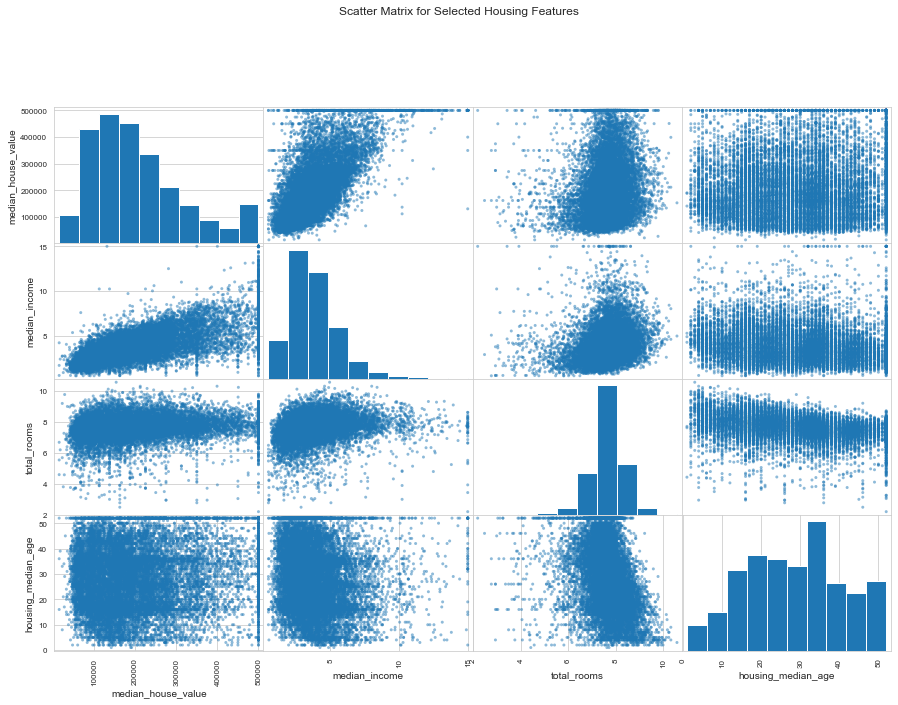

In [47]:
#An other approach is to use a scatterplot in an A vs B fashion
#A problem for this is that with N features you will have N^2 scatter plots

from pandas.plotting import scatter_matrix

# Select features most correlated with median_house_value
imp_atts = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

# Convert boolean columns to integers if necessary
train_data[imp_atts] = train_data[imp_atts].applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Create a scatter matrix for the selected attributes
plt.figure(figsize=(12, 8))  # Adjust the figure size for readability
scatter_matrix(train_data[imp_atts], alpha=0.5, figsize=(15, 10), diagonal='hist')  # Set diagonal to 'hist' for bar graphs

# Display the scatter matrix
plt.suptitle("Scatter Matrix for Selected Housing Features", y=1.02)
plt.show()
